In [112]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

from allen_v1dd.client import EMClient
from allen_v1dd.em import DynamicSynapseGraph
from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups

at.set_stylesheet()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the EM client and synapse graph

In [3]:
em_client = EMClient()

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:24: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [25]:
syn_graph_dir = "/Users/chase/Desktop"
syn_graph_filename = f"{em_client.cave_client.datastack_name}_v{em_client.version}_synapses.gpl"
syn_graph = DynamicSynapseGraph(em_client, debug=True, filename=os.path.join(syn_graph_dir, syn_graph_filename))

Loading graph from file /Users/chase/Desktop/v1dd_v334_synapses.gpl


# Setup stimulus analysis parameters

In [70]:
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v0.h5")

# We can also reduce the number of groups we iterate over by restricting mouse and column
at.set_included_mice([409828])
at.set_included_columns([1])
# at.set_included_volumes([1])

### Example to show all SSI metrics

Text(0, 0.5, 'Cell count')

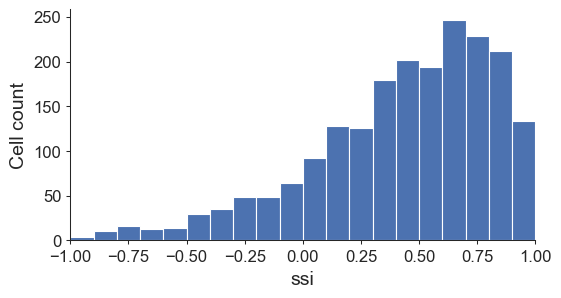

In [77]:
# Example to show the SSI metrics
ssi_metric = "ssi"
roi_to_ssi = {}

for group in iter_plane_groups():
    dgw_responsive = group["drifting_gratings_windowed"]["is_responsive"][()]
    is_ignored_duplicate = group["is_ignored_duplicate"][()]
    roi_inclusion_mask = dgw_responsive# & ~is_ignored_duplicate
    roi_prefix = f"{group.attrs['session_id']}_{group.attrs['plane']}" # e.g., M409828_13_1_456
    roi_ssi_values = group["ssi"][ssi_metric]

    for roi in np.where(roi_inclusion_mask)[0]:
        roi_id = f"{roi_prefix}_{roi}"
        roi_to_ssi[roi_id] = roi_ssi_values[roi]

plt.figure(figsize=(6, 3))
plt.hist(roi_to_ssi.values(), bins=np.arange(-1, 1.1, 0.1))
plt.xlim(-1, 1)
plt.xlabel(ssi_metric)
plt.ylabel("Cell count")

# Load EM mappings

### Root ID --> Cell type

In [101]:
cell_type_df = em_client.get_cell_type_table()
root_id_to_cell_type = pd.Series(index=cell_type_df.pt_root_id.values, data=cell_type_df.cell_type.values)
print(f"{len(root_id_to_cell_type)} cells have cell types")

3760 cells have cell types


### Root ID --> Soma position (microns)

In [106]:
soma_df = em_client.get_soma_positions(None)
root_id_to_soma_pos = pd.Series(index=soma_df.pt_root_id.values, data=soma_df.position_microns.values)
print(f"{len(root_id_to_soma_pos)} cells have soma positions")

# We only care about the cells that have been typed, so only including those
# root_id_to_soma_pos = pd.Series(index=)

155647 cells have soma positions


# Load the coregistered cells

In [142]:
coreg_df = em_client.get_coregistration_table(drop_duplicates=True)
coreg_df.head()

,index,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,0,1,2023-02-14 16:50:14.491563+00:00,t,277703,1,3,14,2,NaN,...,3,M409828_13,3,14,M409828_13_3_14,"[797.7329658575621, 268.4703958902916, 92.8290...",submitted,True,not_started,True
1,1,2,2023-02-14 16:50:14.492369+00:00,t,277515,1,3,60,0,NaN,...,3,M409828_13,1,60,M409828_13_1_60,"[838.0087061146714, 237.58057806602417, 93.975...",submitted,True,not_started,True
2,2,3,2023-02-14 16:50:14.493215+00:00,t,277213,1,3,30,1,NaN,...,3,M409828_13,2,30,M409828_13_2_30,"[790.0267659909371, 248.15872319569212, 76.111...",submitted,True,not_started,True
3,3,4,2023-02-14 16:50:14.494034+00:00,t,293528,1,3,119,4,NaN,...,3,M409828_13,5,119,M409828_13_5_119,"[763.2087486129211, 285.7899063229709, 65.5534...",submitted,True,submitted,True
4,4,5,2023-02-14 16:50:14.494820+00:00,t,277969,1,3,271,1,NaN,...,3,M409828_13,2,271,M409828_13_2_271,"[815.9190761795869, 258.40239635218177, 100.69...",submitted,True,not_started,True


In [143]:
root_id_to_roi = pd.Series(index=coreg_df.pt_root_id.values, data=coreg_df.roi.values)

# Identify the responsive ROIs

In [144]:
coreg_df_dgw_resp = coreg_df[coreg_df.roi.isin(roi_to_ssi.keys())]
coreg_df_dgw_resp

,index,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
2,2,3,2023-02-14 16:50:14.493215+00:00,t,277213,1,3,30,1,NaN,...,3,M409828_13,2,30,M409828_13_2_30,"[790.0267659909371, 248.15872319569212, 76.111...",submitted,True,not_started,True
4,4,5,2023-02-14 16:50:14.494820+00:00,t,277969,1,3,271,1,NaN,...,3,M409828_13,2,271,M409828_13_2_271,"[815.9190761795869, 258.40239635218177, 100.69...",submitted,True,not_started,True
7,7,8,2023-02-14 16:50:14.497189+00:00,t,353321,1,3,158,2,NaN,...,3,M409828_13,3,158,M409828_13_3_158,"[908.9842549292383, 262.8273367395928, 136.837...",submitted,True,not_started,True
11,12,13,2023-02-14 16:50:14.502705+00:00,t,291957,1,3,14,3,NaN,...,3,M409828_13,4,14,M409828_13_4_14,"[819.2184703145202, 282.1793312339397, -5.8660...",submitted,True,not_started,True
19,20,21,2023-02-14 16:50:14.509183+00:00,t,278774,1,3,109,4,NaN,...,3,M409828_13,5,109,M409828_13_5_109,"[843.2239032781479, 287.4299154322512, 138.406...",submitted,True,submitted,True
23,24,25,2023-02-14 16:50:14.512302+00:00,t,276623,1,3,26,1,NaN,...,3,M409828_13,2,26,M409828_13_2_26,"[840.9597999446206, 253.46302660075477, 38.137...",submitted,True,submitted,True
26,27,28,2023-02-14 16:50:14.514975+00:00,t,277414,1,3,29,2,NaN,...,3,M409828_13,3,29,M409828_13_3_29,"[760.7658102606739, 262.70509973701303, 82.432...",submitted,True,submitted,True
28,29,30,2023-02-14 16:50:14.516589+00:00,t,291939,1,3,4,2,NaN,...,3,M409828_13,3,4,M409828_13_3_4,"[801.1350617983032, 266.0704267557839, -7.0636...",submitted,True,not_started,True
31,32,33,2023-02-14 16:50:14.518934+00:00,t,352939,1,3,98,3,NaN,...,3,M409828_13,4,98,M409828_13_4_98,"[930.8804374855777, 280.8903370784687, 111.799...",submitted,True,not_started,True
34,35,36,2023-02-14 16:50:14.521750+00:00,t,278036,1,3,300,2,NaN,...,3,M409828_13,3,300,M409828_13_3_300,"[862.4073937270223, 259.55587707984824, 107.12...",submitted,True,submitted,True


# Plot the SSI of the coreg cells

Text(0.5, 1.0, 'SSI of DGW-responsive, EM-coregistered cells (n=16)')

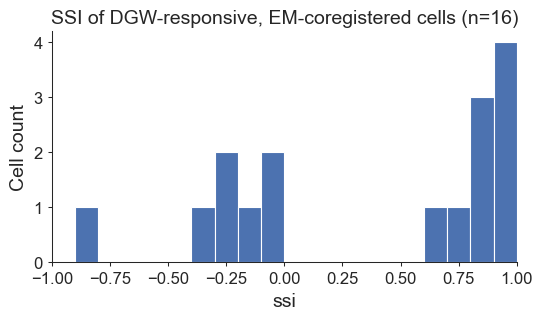

In [145]:
plt.figure(figsize=(6, 3))
plt.hist([roi_to_ssi[x] for x in coreg_df_dgw_resp.roi], bins=np.arange(-1, 1.1, 0.1))
plt.xlim(-1, 1)
plt.xlabel(ssi_metric)
plt.ylabel("Cell count")
plt.title(f"SSI of DGW-responsive, EM-coregistered cells (n={len(coreg_df_dgw_resp)})")

# Pre-load all the dendritic synapses

In [146]:
post_pt_root_ids = coreg_df_dgw_resp.pt_root_id.values
all_den_syn = syn_graph.get_dendritic_synapses(post_pt_root_ids)
all_den_syn

Loading den synapses for 3 neurons.


,pre_pt_root_id,post_pt_root_id,size,soma_soma_dist,soma_soma_dist_horiz
0,864691132773683958,864691132720617684,696,inf,inf
1,864691132773683958,864691132720617684,840,inf,inf
2,864691132773683958,864691132720617684,696,inf,inf
3,864691132773683958,864691132720617684,840,inf,inf
4,864691132773683958,864691132720617684,696,inf,inf
...,...,...,...,...,...
119360,864691132173101350,864691132598451263,671,inf,inf
119361,864691132757992383,864691132598451263,546,inf,inf
119362,864691132835236757,864691132598451263,3687,51.193117,44.890172
119363,864691132562314212,864691132598451263,222,560.498532,441.800780


# Identify the inhibitory inputs onto these cells

  0%|          | 0/16 [00:00<?, ?it/s]

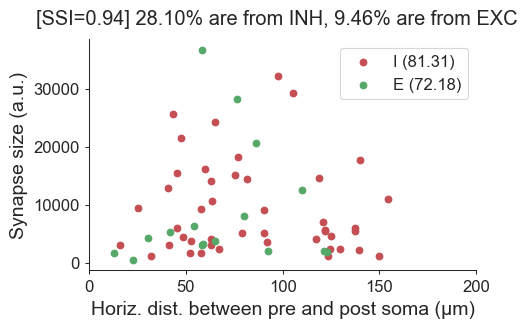

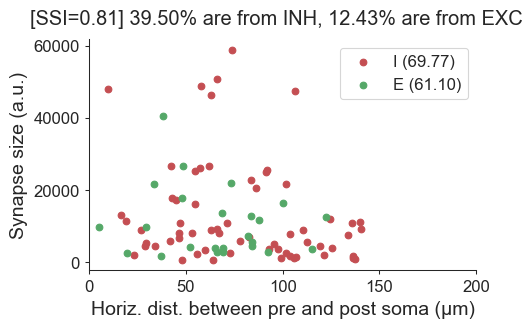

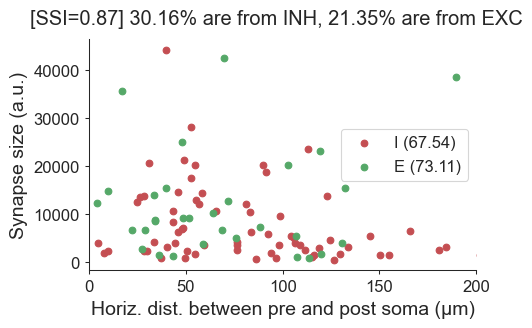

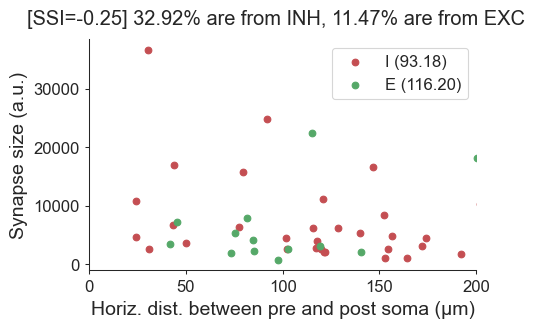

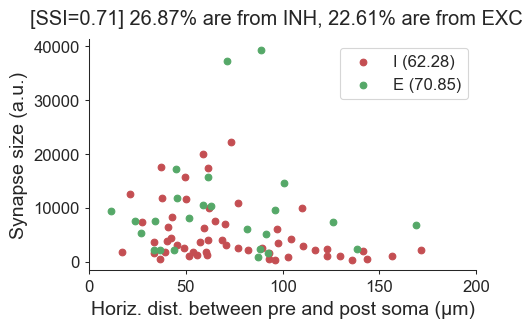

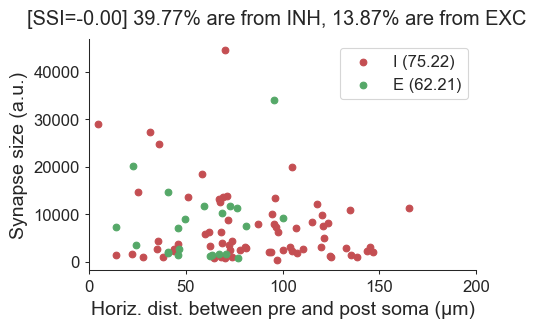

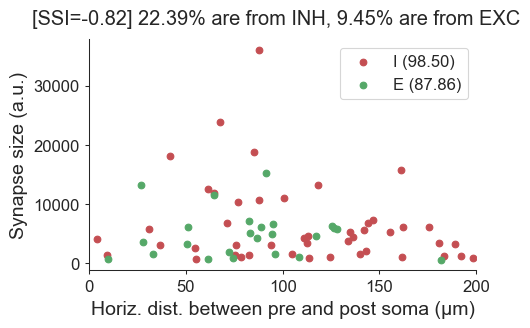

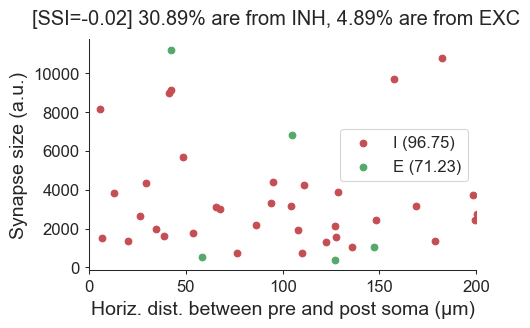

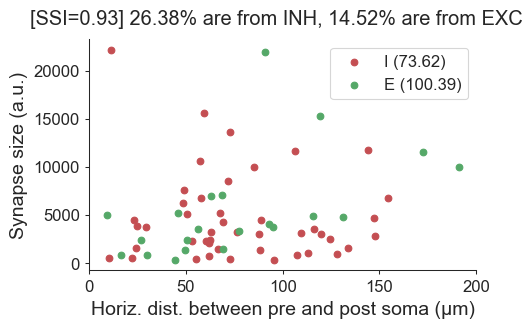

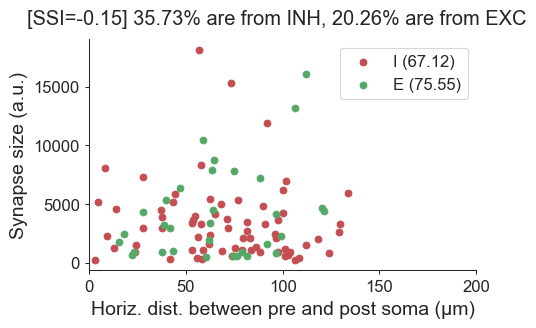

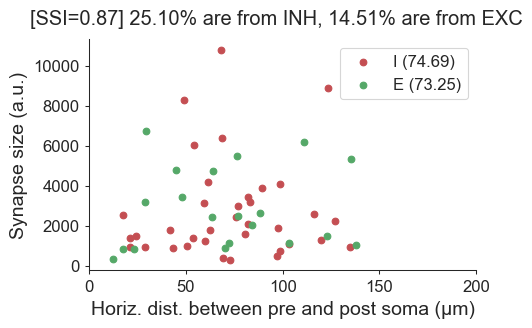

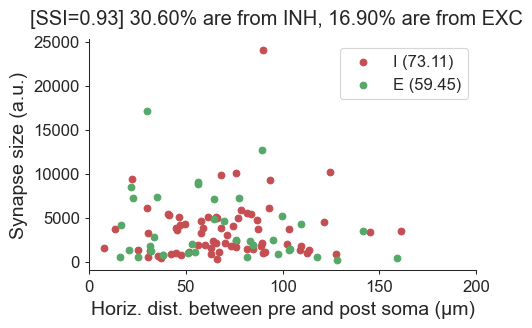

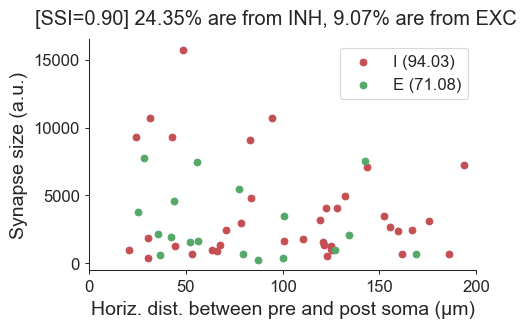

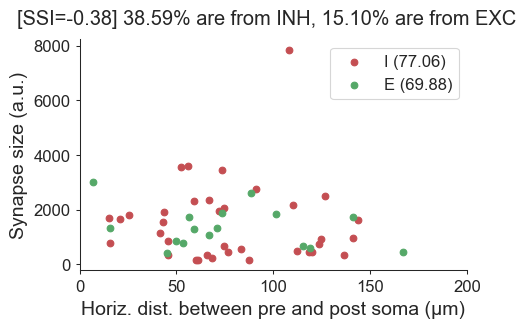

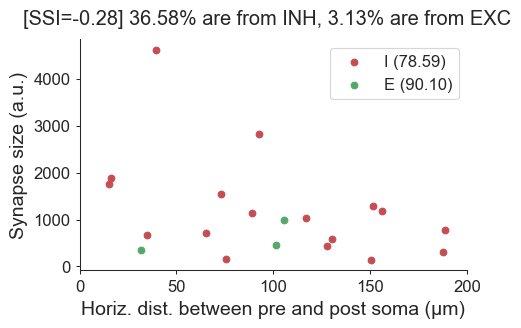

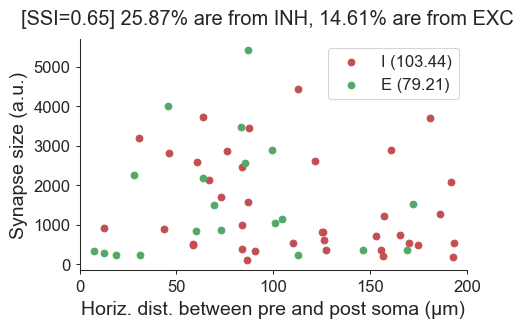

In [154]:
for post_id in tqdm(post_pt_root_ids):
    den_syn = syn_graph.get_dendritic_synapses(post_id).groupby(["pre_pt_root_id", "post_pt_root_id"]).aggregate(dict(
        size="sum",
        soma_soma_dist="first", # these are the same for every (pre, post) pair, so just keep the first
        soma_soma_dist_horiz="first"
    )).reset_index()
    den_syn = den_syn[np.isfinite(den_syn.soma_soma_dist)]
    den_syn_from_inh = den_syn[den_syn.pre_pt_root_id.apply(lambda pre: root_id_to_cell_type.get(pre) in em_client.inh_cell_types)]
    den_syn_from_exc = den_syn[den_syn.pre_pt_root_id.apply(lambda pre: root_id_to_cell_type.get(pre) in em_client.exc_cell_types)]

    wgtavg_inh = np.average(den_syn_from_inh.soma_soma_dist_horiz, weights=den_syn_from_inh["size"])
    wgtavg_exc = np.average(den_syn_from_exc.soma_soma_dist_horiz, weights=den_syn_from_exc["size"])
    label_inh = f"I ({wgtavg_inh:.2f})"
    label_exc = f"E ({wgtavg_exc:.2f})"

    # fig, axs = plt.subplots(figsize=(10, 3), ncols=2)
    # axs[0].scatter(x=den_syn_from_inh.soma_soma_dist_horiz, y=den_syn_from_inh["size"], color="r")
    # axs[1].scatter(x=den_syn_from_exc.soma_soma_dist_horiz, y=den_syn_from_exc["size"], color="g")
    # plt.setp(axs, xlim=(0, 200))

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(x=den_syn_from_inh.soma_soma_dist_horiz, y=den_syn_from_inh["size"], color="r", label=label_inh)
    ax.scatter(x=den_syn_from_exc.soma_soma_dist_horiz, y=den_syn_from_exc["size"], color="g", label=label_exc)
    ax.set_xlim(0, 200)
    ax.legend()
    ax.set_xlabel("Horiz. dist. between pre and post soma (µm)")
    ax.set_ylabel("Synapse size (a.u.)")


    ssi = roi_to_ssi[root_id_to_roi[post_id]]
    fig.suptitle(f'[SSI={ssi:.2f}] {den_syn_from_inh["size"].sum()/den_syn["size"].sum()*100:.2f}% are from INH, {den_syn_from_exc["size"].sum()/den_syn["size"].sum()*100:.2f}% are from EXC')


    # Plot the presynaptic somas for inh
    # den_syn_from_inh
    # ax.set_xlabel("X")
    # ax.set_ylabel("Z")
    # ax.axis("equal")

    # break